# FaceGAN


Hello! In this notebook we'll train a GAN to generate images of faces. We'll set up the dataset, ... TODO fill in overview



In [1]:
%matplotlib inline

# Functions for training neural network
from tools import *
import torch
import torch.optim as optim

# Functions for visualizations
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

## Data

...instructions on how to download zip file, extract, and place under 'data' folder...

To train a GAN, we need to keep giving it examples of what real images should look like. Right now, we have a folder with all of these images. How do we go from images saved as files on our computer to images in number-form that are ready for a neural network to use?

Fortunately, the machine learning framework that we are using called PyTorch can do this for us. We've placed most of the PyTorch code for this in the file **tools/data.py**, but this is what it's doing behind the scenes:

1. Reads each image file into a list of numbers that specify the color at each pixel
2. Processes each image to the correct size and range of values
3. Creates a **data loader**, which keeps track of which images the GAN used already so it can keep giving it new ones in each round of training

The code below creates the data loader and plots some sample images.


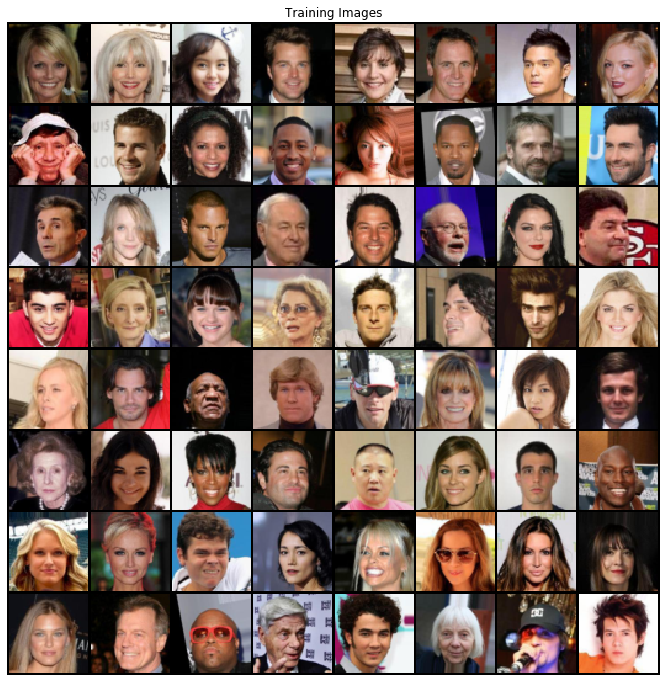

In [2]:
# Folder where images are stored
dataroot = "data/faces"

# Batch size: number of images the GAN sees in one round of training
batch_size = 128

# Size of images, in pixels (they will be square)
image_size = 64

dataloader = get_dataloader(dataroot, image_size, batch_size)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(12,12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

### Input to the generator

Remember that the input to the generator model is just a random bunch of numbers.
Let's see what that looks like - it'll help you appreciate how difficult this problem is!

Note: The actual input is 1-dimensional - just a list of numbers. We'll create noise in the shape of a square just for visualization.

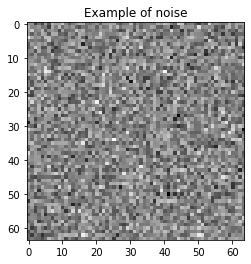

In [3]:

noise = torch.randn(64,64)
plt.imshow(noise, cmap='gray')
plt.title('Example of noise')
plt.show()

## Creating the models


Let's now create the generator and discriminator models.

In [4]:
# Size of noise vector (i.e. size of generator input)
noise_size = 100

# Use a GPU if available, otherwise use the CPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


generator     = Generator(noise_size).to(device)
discriminator = Discriminator().to(device)

# Initialize the weights of the networks
generator.apply(initialize_weights)
discriminator.apply(initialize_weights)

# Print out the network structure
print('Generator structure:')
print(generator)
print('\n')

print('Discriminator structure:')
print(discriminator)

Generator structure:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  

## Training the GAN

We'll now 

In [5]:
# Training settings
number_of_epochs = 2
learning_rate    = 0.0002


# Create optimizers, which are functions that will update the models for us
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
generator_optimizer     = optim.Adam(generator.parameters(),     lr=learning_rate, betas=(0.5, 0.999))

# Create batch of noise that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, noise_size, 1, 1, device=device)



In [11]:
# Training Loop

# Lists to keep track of progress
sample_generator_images = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

# For each epoch
for epoch in range(number_of_epochs):
    print('Starting epoch {}'.format(epoch))
    
    # For each batch in the dataloader
    for iteration, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        
        # Parse data into the correct format for training
        real_images, labels_real, labels_fake, noise = format_data(data, device, noise_size)
        
        ############################
        # (1) Update Discriminator
        ###########################
        discriminator.zero_grad()
        
        # Train discriminator on all-real batch
        predictions_on_real = discriminator(real_images)
        loss_on_real        = calculate_loss(predictions_on_real, labels_real)
        
        # Train discriminator on all-fake batch
        fake_images         = generator(noise)
        predictions_on_fake = discriminator(fake_images.detach())
        loss_on_fake        = calculate_loss(predictions_on_fake, labels_fake)
        
        # Update the discriminator model
        discriminator_loss = loss_on_real + loss_on_fake
        update(discriminator_optimizer, discriminator_loss)
        

        ############################
        # (2) Update Generator
        ###########################
        generator.zero_grad()
        
        # Try to fool discriminator into predicting that fake images are real
        predictions_on_fake = discriminator(fake_images)
        generator_loss      = calculate_loss(predictions_on_fake, labels_real)
        update(generator_optimizer, generator_loss)

        # Output training stats every 100 iterations
        if iteration % 100 == 0:
            print('Iteration %d.\tLoss_D: %.4f\tLoss_G: %.4f\tProb real: %.4f\tProb fake: %.4f'
                  % (iteration,
                     discriminator_loss.item(),
                     generator_loss.item(),
                     predictions_on_real.mean().item(),
                     predictions_on_fake.mean().item()))
            
        # Save Losses for plotting later
        G_losses.append(generator_loss.item())
        D_losses.append(discriminator_loss.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == number_of_epochs-1) and (iteration == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            sample_generator_images.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
Starting epoch 0


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbaceb62290>
Traceback (most recent call last):


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbaceb62290>
  File "/home/spetryk/miniconda3/envs/py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/home/spetryk/miniconda3/envs/py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
  File "/home/spetryk/miniconda3/envs/py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    self._shutdown_workers()
    w.join()
  File "/home/spetryk/miniconda3/envs/py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
  File "/home/spetryk/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 138, in join
    w.join()
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/home/spetryk/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 

Iteration 0.	Loss_D: 0.2999	Loss_G: 3.9179	Prob real: 0.8838	Prob fake: 0.0321
Iteration 100.	Loss_D: 1.1779	Loss_G: 1.0532	Prob real: 0.4050	Prob fake: 0.4323
Iteration 200.	Loss_D: 0.4009	Loss_G: 2.9833	Prob real: 0.7834	Prob fake: 0.0700
Iteration 300.	Loss_D: 0.4362	Loss_G: 2.1558	Prob real: 0.7221	Prob fake: 0.1574
Iteration 400.	Loss_D: 0.4443	Loss_G: 4.6946	Prob real: 0.9089	Prob fake: 0.0162
Iteration 500.	Loss_D: 0.5367	Loss_G: 3.9392	Prob real: 0.8709	Prob fake: 0.0302
Iteration 600.	Loss_D: 0.3903	Loss_G: 2.4848	Prob real: 0.7737	Prob fake: 0.1144
Iteration 700.	Loss_D: 0.4770	Loss_G: 2.7506	Prob real: 0.7206	Prob fake: 0.0948
Iteration 800.	Loss_D: 0.9484	Loss_G: 5.1934	Prob real: 0.9156	Prob fake: 0.0099
Iteration 900.	Loss_D: 0.5014	Loss_G: 1.6688	Prob real: 0.7303	Prob fake: 0.2409
Iteration 1000.	Loss_D: 0.4114	Loss_G: 2.8114	Prob real: 0.7597	Prob fake: 0.0935
Iteration 1100.	Loss_D: 1.3377	Loss_G: 5.7379	Prob real: 0.9382	Prob fake: 0.0065


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbaceb62290>
Traceback (most recent call last):
  File "/home/spetryk/miniconda3/envs/py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/spetryk/miniconda3/envs/py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/home/spetryk/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbaceb62290>
Traceback (most recent call last):
  File "/home/spetryk/miniconda3/envs/py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/spetryk/miniconda3/envs/py37/lib/python3.7/site-packag

Iteration 1200.	Loss_D: 0.9380	Loss_G: 1.2381	Prob real: 0.5016	Prob fake: 0.3817
Iteration 1300.	Loss_D: 0.4169	Loss_G: 2.7697	Prob real: 0.7693	Prob fake: 0.0896
Iteration 1400.	Loss_D: 0.5680	Loss_G: 3.1705	Prob real: 0.9110	Prob fake: 0.0565
Iteration 1500.	Loss_D: 0.6499	Loss_G: 2.7586	Prob real: 0.7054	Prob fake: 0.0891

Starting epoch 1


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbaceb62290>
Traceback (most recent call last):
  File "/home/spetryk/miniconda3/envs/py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/spetryk/miniconda3/envs/py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/home/spetryk/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbaceb62290>
Traceback (most recent call last):
  File "/home/spetryk/miniconda3/envs/py37/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/spetryk/miniconda3/envs/py37/lib/python3.7/site-packag

Iteration 0.	Loss_D: 1.0760	Loss_G: 5.6303	Prob real: 0.8652	Prob fake: 0.0082
Iteration 100.	Loss_D: 0.9382	Loss_G: 3.1507	Prob real: 0.8287	Prob fake: 0.0607
Iteration 200.	Loss_D: 0.6568	Loss_G: 2.1388	Prob real: 0.6380	Prob fake: 0.1533



KeyboardInterrupt: 